In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import math
import scipy as sp
import copy
import os
import matplotlib.pyplot as plt
from libwallerlab.projects.motiondeblur import blurkernel
import bluranalysis as analysis

# plt.style.use('deblur')

# Define System Parameters

In [56]:
# Figure output directory
figure_directory = os.path.expanduser('~/Dropbox/Berkeley/Phase-Deblurring/journalpaper/figures/')

# Define arguments struct for functions
system_params = {'pixel_count': (2580, 2180),
                 'numerical_aperture': 0.25,
                 'magnification': 10,
                 'pixel_size': 6.5e-6,
                 'illumination_min_pulse_time': 4e-6, # s
                 'motion_settle_time': 0.25, # seconds
                 'motion_acceleration': 1e4, # mm / s / s
                 'motion_velocity_max': 40, # mm / s
                 'illumination_beta': 0.5,
                 'motion_axis': 1,
                 'illuminance': 10, # lux
                 'n_tests': 25,
                 'camera_is_color': True,
                 'camera_readout_time': 0.016, # seconds
                 'camera_quantum_efficency': 0.4
                }

## Calculating Single-LED Illuminance Per pixel
Lumens are candela / steradian
Lux are lumens / sq. meter


In [2]:
ps = 6.5e-6 / 10
dist = 0.05
candela = 2.5
angle = np.arctan2(ps / 2, dist)

# First definition
lumens = angle * candela
lux = lumens / ps
print(lux)

# Second definition
lux = candela / dist ** 2  
print(lux)

24.999999999647915
999.9999999999998


## Calculating Photon Rate (Photons / px / second) of a single pixel

In [58]:
analysis.illuminanceToPhotonPixelRate(1000 * 40, **system_params) * 0.007 * 0.4

12033.565001570008

## Calculate SNR using camera parameters
$ SNR = \frac{I Q t}{\sqrt{I  Q t + N_d t + N_r^2}} $

- Quantum efficency is exactly the amount of photons which convert to electrons
- I is photon flux (photons / px / s). This is the output of exposureToCounts

**Need to relate photon flux to radiance.**

1. Convert illuminance to photons per second
2. convert photons to second and exposure time to SNR

---
Led Datasheet: https://www.mouser.com/datasheet/2/423/VAOL-3LWY4-1064901.pdf

In [59]:
# Calculate photon pixel rate (photons / px / s)
photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(9000, **system_params)
print("A single pixel would have a background of %g counts (before detection) and %g measured counts" % (photon_pixel_rate * 0.07, photon_pixel_rate * 0.07 * 0.4))

# Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
snr = analysis.photonPixelRateToSnr(photon_pixel_rate, 0.007, **system_params)
print("This pixel would have a snr of %g" % snr)

A single pixel would have a background of 67688.8 counts (before detection) and 27075.5 measured counts
This pixel would have a snr of 51.9741


## Loop Over Illuminance vs. SNR

<IPython.core.display.Javascript object>


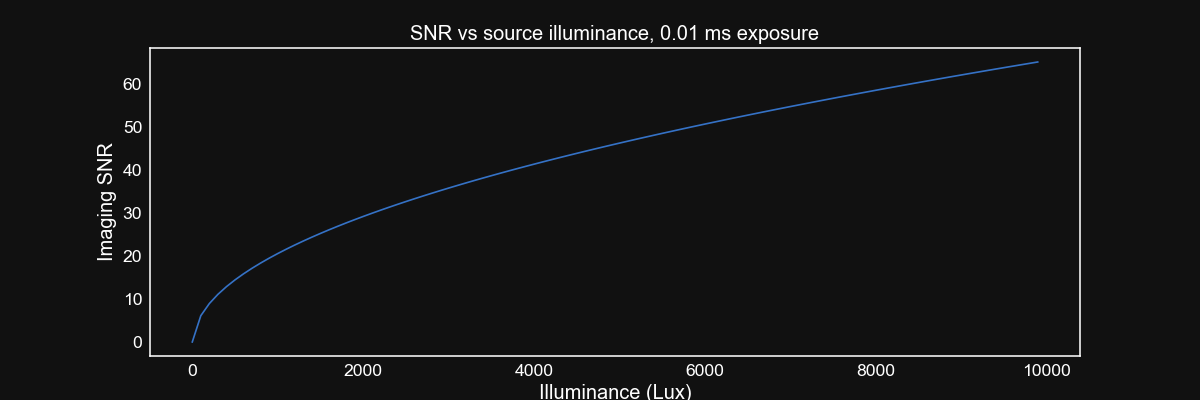

Text(0.5, 1.0, 'SNR vs source illuminance, 0.01 ms exposure')

In [60]:
exposure_time = 0.01

illuminance_list = np.arange(0, 10000, 100)
snr_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_params)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    snr = analysis.photonPixelRateToSnr(photon_pixel_rate, exposure_time, **system_params)
    
    # Append
    snr_list.append(snr)
    
plt.figure()
plt.plot(illuminance_list, snr_list)
plt.xlabel('Illuminance (Lux)')
plt.ylabel('Imaging SNR')
plt.title('SNR vs source illuminance, %g ms exposure' % exposure_time)

## Create convenience function for converting system parameters to SNR

In [61]:
exposure_time = 0.007

# Calculate SNR
snr = analysis.exposureTimeToSnr(exposure_time, **system_params)
print('An exposure time of %g s would have a SNR of %g' % (exposure_time, snr))

# Calculate noise ratio
signal_mean, sigma_dependent, sigma_independent = analysis.exposureTimeToNoiseComponents(exposure_time, **system_params)
print('An exposure time of %g s would see %d counts and have a noise ratio of %g' % (exposure_time, signal_mean, (sigma_dependent / sigma_independent)))

An exposure time of 0.007 s would have a SNR of 0.988368
An exposure time of 0.007 s would see 3 counts and have a noise ratio of 0.693439


## Relating to Flourescense
The output of a flourophore is proportional to two parameters:
- Quantum yield: energy out / energy in
- Molar Extinction coefficient: Amount of energy absorption per mole of flourophores.
---
The molar extinction coefficient is related to absorption $A$ by the following relationship:
$$ A = \epsilon L c $$

Assume a square cell of size $10\mu m ^3$ which is fully tagged with GFP (one mole of flourophores per cell). GFP has a molar extinction coefficient $\epsilon = 21000$ and a Quantum yeild of 0.77. The absorption will be:

$$A = 21000 \times 10^{-5} \times 1.0 = 0.21$$

Absorption is related to fractional flux by the equation:

$$\alpha = \frac{\Phi_{abs}}{\Phi_{in}} = 10^{-A} $$

In this case, we find that $\alpha = 0.61$. The Quantum yeild stacks with this parameter to give the total reduction in power as:

$$\frac{\Phi_{in}}{\Phi_{out}} = 0.61 * 0.77 = 0.47 $$

So, moving to flourescense will reduce photon flux by at least 50\%, and likely much more due to flourophores being sparse. This factor linearally scales with illuminance.

However, since we can't really model how flourophores attach, is probably isn't a great upper bound (as in, it's accurate, but the real attenuation will be much lower). We also use a brighter source, which should be factored in.


---
Sources:
- https://www.aatbio.com/resources/faq-frequently-asked-questions/What-is-a-molar-extinction-coefficient
- https://www.thermofisher.com/us/en/home/references/molecular-probes-the-handbook/introduction-to-fluorescence-techniques.html
- https://www.microscopyu.com/techniques/fluorescence/introduction-to-fluorescent-proteins

## Laser pointer intensity
https://physics.stackexchange.com/questions/156914/whats-the-intensity-of-a-laser-pointer

In [62]:
r = 0.5e-3 # beam radius
area = 3.14 * r ** 2
laser_power = 5e-3
laser_radiance = laser_power / area
laser_lux = laser_radiance / 600 # emits at 532nm

print('A %g mw laser with a %g mm beam diameter would emit %g W/m^2, which is %g lux.' % (laser_power * 1e3, r * 2000, laser_radiance, laser_lux))

A 5 mw laser with a 1 mm beam diameter would emit 6369.43 W/m^2, which is 10.6157 lux.


<IPython.core.display.Javascript object>


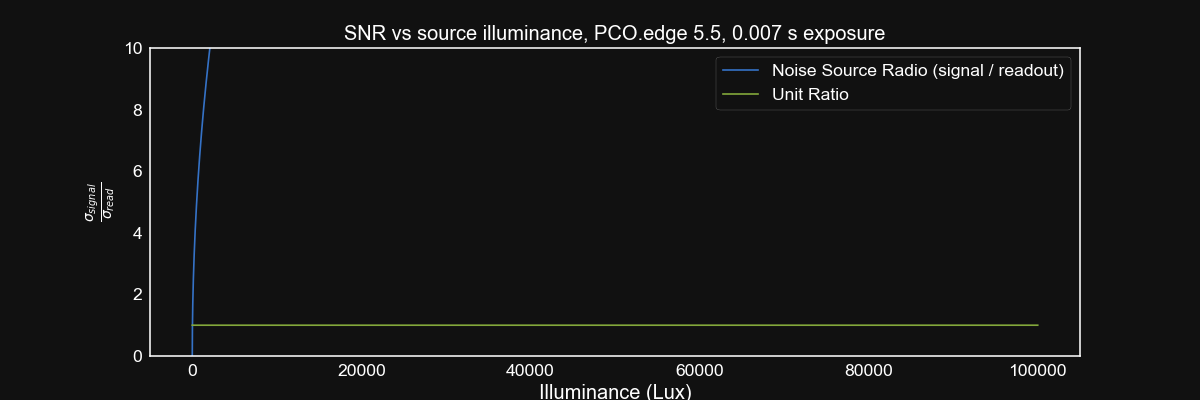

Text(0.5, 1.0, 'SNR vs source illuminance, PCO.edge 5.5, 0.007 s exposure')

In [63]:
exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 1)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_params)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_params)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list, label='Noise Source Ratio (signal / readout)')
plt.plot(illuminance_list, [1] * len(snr_ratio_list), label='Unit Ratio')
plt.xlabel('Illuminance (Lux)')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
plt.ylim((0,10))
plt.legend()
plt.title('SNR vs source illuminance, PCO.edge 5.5, %g s exposure' % exposure_time)

# Observe the effect of using a 20x objective

<IPython.core.display.Javascript object>


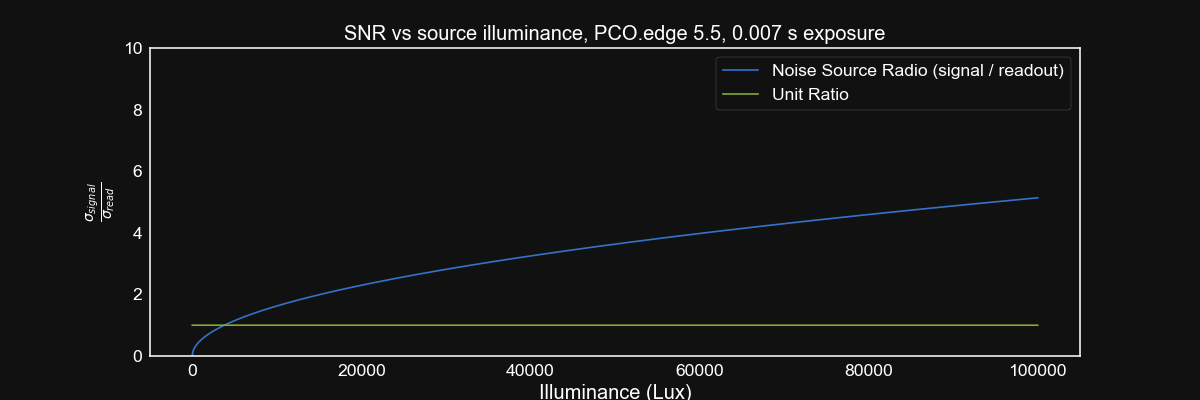

Text(0.5, 1.0, 'SNR vs source illuminance, PCO.edge 5.5, 0.007 s exposure')

In [21]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.4,
                     'pixel_size': 6.5e-6, # x2 for color
                     'magnification': 20,
                     'quantum_efficency': 0.4, # 0.4 for color, 0.6 for monochrome
                     'dark_current': 0.9,
                     'readout_noise': 2.5,
                     'illuminance': 40000, # 40 LEDs
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 1)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list, label='Noise Source Ratio (signal / readout)')
plt.plot(illuminance_list, [1] * len(snr_ratio_list), label='Unit Ratio')
plt.xlabel('Illuminance (Lux)')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
plt.ylim((0,10))
plt.legend()
plt.title('SNR vs source illuminance, PCO.edge 5.5, %g s exposure' % exposure_time)

# Sweep Motion Velocity at high frame rates

In [54]:
def acquisitionParameters(camera_frame_rate=10, pixel_size=6.5e-6,
                          camera_readout_time=0.016, camera_max_counts=65535,
                          camera_quantum_efficency=1.0, pulse_count=None,
                          motion_velocity=None, motion_velocity_max=40,
                          pixel_count=(2580, 2180), motion_axis=1,
                          illumination_min_pulse_time=4e-6,
                          illuminance=1, numerical_aperture=1.0, 
                          magnification=1, debug=True, **kwargs):

    # Calculate effective pixel size
    system_pixel_size = pixel_size / magnification

    # Calculate FOV in meters
    fov = [p * system_pixel_size for p in pixel_count]

    # Calculate frame time
    frame_time = 1 / camera_frame_rate

    # Calculate camera exposure time
    exposure_time_max = frame_time - camera_readout_time

    # Ensure exposure time isn't too short
    if exposure_time_max <= 0:
        return (0, 0, 0, 0)  # Zero signal, dnf = 1

    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance,
                                                     numerical_aperture,
                                                     pixel_size,
                                                     magnification)

    # Calculate camera measured counts rate (counts / px / s)
    exposure_rate = photon_pixel_rate * camera_quantum_efficency

    # Determine maximum number of exposure units which would saturate the camera
    exposure_saturation_time = camera_max_counts / exposure_rate

    # Calculate velocity if not provided
    if motion_velocity is None:
        motion_velocity = fov[motion_axis] / frame_time

    # Check if motion velocity is too low to capture all frames
    if motion_velocity > motion_velocity_max:
        print('Necessary velocity (%g m/s) exceeds maximum velocity (%g m/s))' % (motion_velocity, motion_velocity_max))
        return (0, 0, 0, 0)  # Zero signal, dnf = 1

    # Calculate required LED array update speed
    pulse_time = min(system_pixel_size / motion_velocity, exposure_time_max)

    # Ensure strobe time isn't too fast for hardware
    if pulse_time < illumination_min_pulse_time:
        print('Necessary pulse time (%g ms) exceeds min pulse time (%g ms))' % (pulse_time * 1000, illumination_min_pulse_time * 1000))
        return (0, 0, 0, 0)  # Zero signal, dnf = 1
    
    return pulse_time, motion_velocity, exposure_rate, exposure_saturation_time


# Define arguments struct for functions
system_params = {'pixel_count': (2580, 2180),
                 'numerical_aperture': 0.25,
                 'magnification': 10,
                 'pixel_size': 6.5e-6,
                 'illumination_min_pulse_time': 4e-6, # s
                 'motion_settle_time': 0.25, # seconds
                 'motion_acceleration': 1e4, # mm / s / s
                 'motion_velocity_max': 40, # mm / s
                 'illumination_beta': 0.5,
                 'motion_axis': 1,
                 'illuminance': 40000, # lux
                 'n_tests': 25,
                 'camera_is_color': True,
                 'camera_readout_time': 0.016, # seconds
                 'camera_quantum_efficency': 0.4,
                 'debug':True
                }

pulse_time, motion_velocity, exposure_rate, exposure_saturation_time = acquisitionParameters(**system_params)
print((pulse_time, motion_velocity, exposure_rate, exposure_saturation_time))

(4.587155963302752e-05, 0.014169999999999999, 1719080.714510001, 0.038122119250625065)


<IPython.core.display.Javascript object>


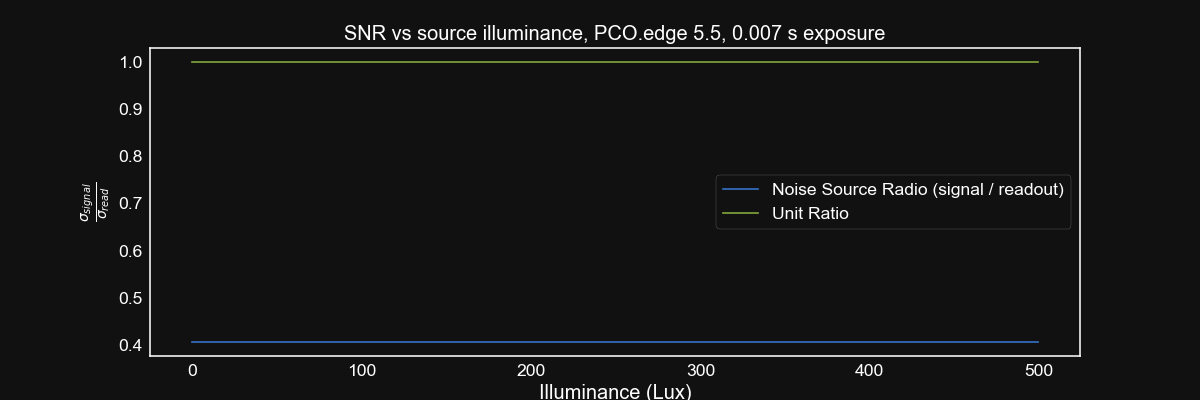

Text(0.5, 1.0, 'SNR vs source illuminance, PCO.edge 5.5, 0.007 s exposure')

In [32]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6, # x2 for color
                     'magnification': 10,
                     'quantum_efficency': 0.4, # 0.4 for color, 0.6 for monochrome
                     'dark_current': 0.9,
                     'readout_noise': 2.5,
                     'illuminance': 40000, # 40 LEDs
                     'pulse_time': 40e-8,
                     'motion_velocity_max': 1e8,
                     'max_count': 65535
                    }

exposure_time = 0.007

velocity_list = np.arange(0.1, 500, 1)
snr_ratio_list = []
illuminance = 40000

for velocity in velocity_list:
    
    # Define velocity
    system_parameters['motion_velocity'] = velocity
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(velocity_list, snr_ratio_list, label='Noise Source Ratio (signal / readout)')
plt.plot(velocity_list, [1] * len(snr_ratio_list), label='Unit Ratio')
plt.xlabel('Illuminance (Lux)')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
# plt.ylim((0,10))
plt.legend()
plt.title('SNR vs source illuminance, PCO.edge 5.5, %g s exposure' % exposure_time)

# Sweep the number of LEDs

In [ ]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6, # x2 for color
                     'magnification': 10,
                     'quantum_efficency': 0.4, # 0.4 for color, 0.6 for monochrome
                     'dark_current': 0.9,
                     'readout_noise': 2.5,
                     'illuminance': 40000, # 40 LEDs
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 12000, 10)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list / 1000, snr_ratio_list)
plt.plot(illuminance_list / 1000, [1] * len(snr_ratio_list))
plt.xlabel('# LEDs')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
# plt.ylim((0,3))
plt.title('SNR vs source illuminance, PCO.edge 5.5, %g s exposure' % exposure_time)

# Camera Analysis

## PCO.edge 5.5

In [ ]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6, # x2 for color
                     'magnification': 10,
                     'quantum_efficency': 0.4, # 0.4 for color, 0.6 for monochrome
                     'dark_current': 0.9,
                     'readout_noise': 2.5,
                     'illuminance': 40000, # 40 LEDs
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 10)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list)
plt.plot(illuminance_list, [1] * len(snr_ratio_list))
plt.xlabel('Illuminance (Lux)')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
# plt.ylim((0,3))
plt.title('SNR vs source illuminance, PCO.edge 5.5, %g s exposure' % exposure_time)

## Optimos

In [ ]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6, # x2 for color
                     'magnification': 10,
                     'quantum_efficency': 0.4, # 0.4 for color, 0.6 for monochrome
                     'dark_current': 0.9,
                     'readout_noise': 1.9,
                     'illuminance': 40000, # 40 LEDs
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 10)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list)
plt.plot(illuminance_list, [1] * len(snr_ratio_list))
plt.xlabel('Illuminance (Lux)')
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
# plt.ylim((0,3))
plt.title('SNR vs source illuminance, Optimos, %g s exposure' % exposure_time)

## Retiga R3

In [ ]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6,
                     'magnification': 10,
                     'quantum_efficency': 0.75,
                     'dark_current': 1.8,
                     'readout_noise': 5.5,
                     'illuminance': 40000,
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 10)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list)
plt.plot(illuminance_list, [1] * len(snr_ratio_list))
plt.xlabel('Illuminance (Lux)')
plt.ylim((0,3))
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
plt.title('SNR vs source illuminance, Retiga R3, %g s exposure' % exposure_time)

## Thorlabs Camera

In [ ]:
# Define system parameters
system_parameters = {'numerical_aperture': 0.25,
                     'pixel_size': 6.5e-6,
                     'magnification': 10,
                     'quantum_efficency': 0.75,
                     'dark_current': 1,
                     'readout_noise': 10,
                     'illuminance': 40000,
                     'pulse_time': 40e-6,
                     'max_count': 65535
                    }

exposure_time = 0.007

illuminance_list = np.arange(0, 100000, 10)
snr_ratio_list = []
for illuminance in illuminance_list:
    
    # Calculate photon pixel rate (photons / px / s)
    photon_pixel_rate = analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters)

    # Calculate SNR using photon pixel rate (photons / px / s) and exposure time (s)
    _, snr_dep, snr_indep = analysis.photonPixelRateToNoiseComponents(photon_pixel_rate, exposure_time, **system_parameters)
    
    if snr_indep  == 0:
        snr_indep = 1
        
    # Append
    snr_ratio_list.append(snr_dep / snr_indep)
    
plt.figure()
plt.plot(illuminance_list, snr_ratio_list)
plt.plot(illuminance_list, [1] * len(snr_ratio_list))
plt.xlabel('Illuminance (Lux)')
plt.ylim((0,3))
plt.ylabel('$\\frac{\\sigma_{signal}}{\\sigma_{read}}$')
plt.title('SNR vs source illuminance, Thorlabs Camera, %g s exposure' % exposure_time)